Liver Disease Explainable AI System

Load Data

In [1]:
import pandas as pd
train = pd.read_csv('data/Training_indian_liver_disease_dataset.csv')
test = pd.read_csv('data/Testing_indian_liver_disease_dataset.csv')

Preprocessing

In [ ]:
train = train.drop('Patient_ID', axis=1) #patiend id has no relevance to the model, so we can drop it
test = test.drop('Patient_ID', axis=1)
from sklearn.preprocessing import LabelEncoder  #encodes all labels to numeric values, which is necessary for machine learning models
cat_cols = train.select_dtypes(include='object').columns
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str)) #transforming the test data using the same encoder fitted on the training data to ensure consistency
    encoders[col] = le

Feature Engineering

In [ ]:
train['AST_ALT_ratio'] = train['AST']/(train['ALT']+1e-6) #adding a small value to the denominator to avoid division by zero
train['BMI_Alcohol'] = train['BMI']*train['Alcohol_Consumption'] #creating an interaction feature between BMI and Alcohol Consumption, as they may have a combined effect on liver disease risk
train['Bilirubin_Albumin'] = train['Bilirubin']/(train['Albumin']+1e-6)
test['AST_ALT_ratio'] = test['AST']/(test['ALT']+1e-6) 
test['BMI_Alcohol'] = test['BMI']*test['Alcohol_Consumption']
test['Bilirubin_Albumin'] = test['Bilirubin']/(test['Albumin']+1e-6)

Train Binary Model

In [ ]:
target='Liver_Disease_Type'
X_train=train.drop(target,axis=1)
y_train=train[target]
X_test=test.drop(target,axis=1)
y_test=test[target]
y_train_binary=(y_train!=0).astype(int)
y_test_binary=(y_test!=0).astype(int)
from xgboost import XGBClassifier
model_bin=XGBClassifier(n_estimators=800,max_depth=10,learning_rate=0.03)
model_bin.fit(X_train,y_train_binary) #fitting the model on the training data

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

model_multi = XGBClassifier(
    n_estimators=800, #number of trees in the ensemble
    max_depth=10, #maximum depth of each tree, allowing the model to capture complex patterns in the data
    learning_rate=0.03, #step size shrinkage used to prevent overfitting by making the model more conservative,slow learning
    objective="multi:softprob", #specifies that we are performing multi-class classification and want probability outputs for each class
    eval_metric="mlogloss" #(multiclass logarithmic loss) a evaluation metric for multi-class classification, which measures the performance of the model during training
)

model_multi.fit(X_train, y_train)

preds_multi = model_multi.predict(X_test)

print("Multi-class Accuracy:", accuracy_score(y_test, preds_multi))
print(classification_report(y_test, preds_multi))

Multi-class Accuracy: 0.9213333333333333
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       195
           1       0.95      0.91      0.93       180
           2       0.93      0.98      0.96       540
           3       0.85      0.82      0.84       120
           4       0.76      0.72      0.74        90
           5       0.97      0.94      0.96       375

    accuracy                           0.92      1500
   macro avg       0.89      0.88      0.88      1500
weighted avg       0.92      0.92      0.92      1500



Evaluate

In [ ]:
from sklearn.metrics import accuracy_score
preds_bin=model_bin.predict(X_test)
print(accuracy_score(y_test_binary,preds_bin)) 

0.9673333333333334


Patient Input

In [ ]:
patient={'Age':45,'Gender':1,'Occupation':2,'BMI':28,'Obesity_Class':1,'Diet_Quality':2,
'Physical_Activity':1,'Sleep_Hours':6,'Smoking_Status':1,'Alcohol_Consumption':3,
'Sym_Fatigue':1,'Sym_Jaundice':0,'Sym_Abdominal_Pain':1,'Sym_Itching':0,'Sym_Ascites':0,
'Sym_Dark_Urine':1,'Sym_Weight_Loss':0,'Comorb_Diabetes':1,'Comorb_Hypertension':0,
'Comorb_Genetic_History':0,'ALT':65,'AST':70,'Bilirubin':1.8,'Albumin':3.2,'Platelets':210,
'Alk_Phosphatase':180} #creating a sample patient profile with various features relevant to liver disease risk

Prediction Pipeline

In [ ]:
import numpy as np
patient_df=pd.DataFrame([patient])
patient_df['AST_ALT_ratio']=patient_df['AST']/(patient_df['ALT']+1e-6) #creating the same features for the patient profile as were used in the model training to ensure consistency
patient_df['BMI_Alcohol']=patient_df['BMI']*patient_df['Alcohol_Consumption']
patient_df['Bilirubin_Albumin']=patient_df['Bilirubin']/(patient_df['Albumin']+1e-6)
patient_df=patient_df[X_train.columns]
prob=model_bin.predict_proba(patient_df)[0][1]
pred=model_bin.predict(patient_df)[0]

Risk Score

In [ ]:
def risk_category(prob):
    return 'High Risk' if prob>0.85 else 'Moderate Risk' if prob>0.6 else 'Low Risk'
risk=risk_category(prob) #categorizing the predicted probability into risk categories for better interpretability
print(pred,prob,risk)

0 0.10083022 Low Risk


Explainability

C:\Users\nanda\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


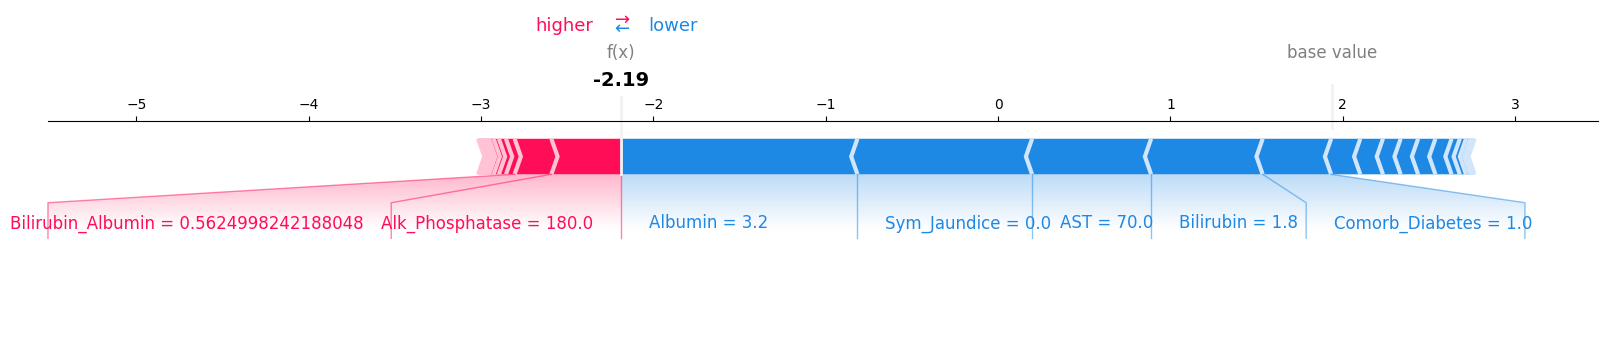

In [ ]:
import shap
explainer=shap.TreeExplainer(model_bin) #creating a SHAP explainer object for the trained XGBoost model, which will be used to compute SHAP values for the patient profile
shap_values=explainer.shap_values(patient_df)
shap.force_plot(explainer.expected_value,shap_values[0],patient_df,matplotlib=True)

SHAP Summary for Class 0


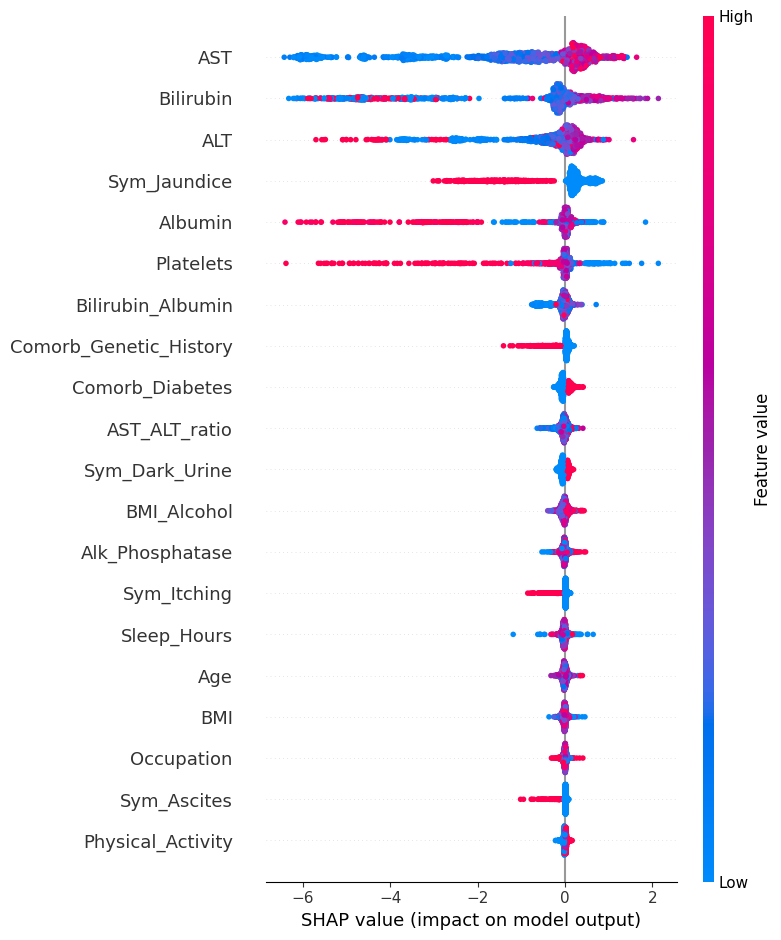

SHAP Summary for Class 1


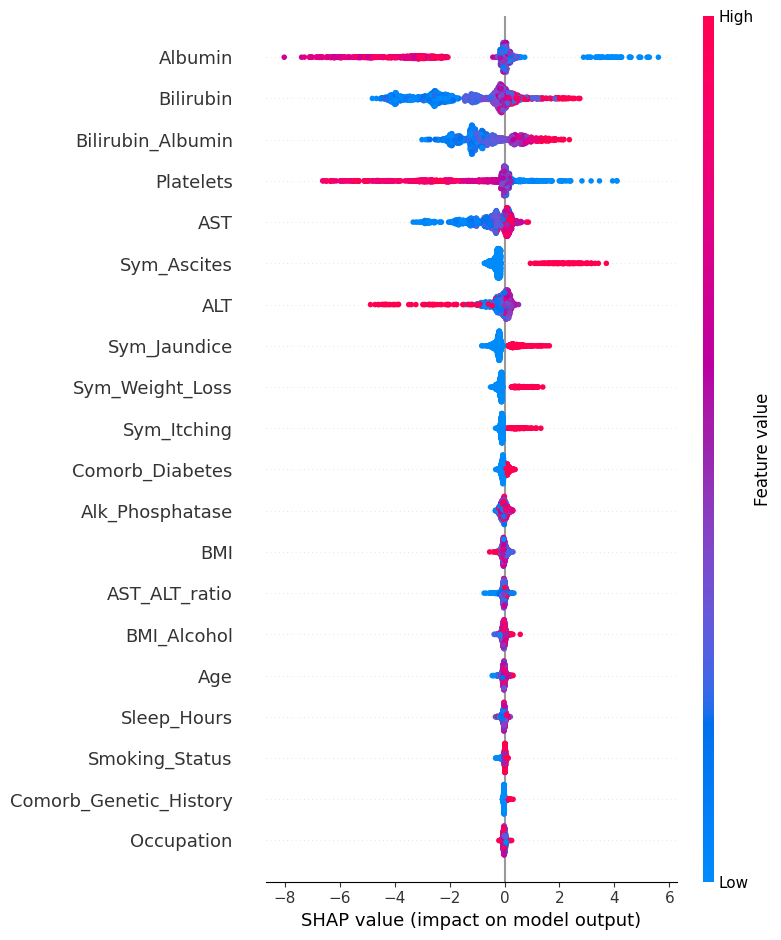

SHAP Summary for Class 2


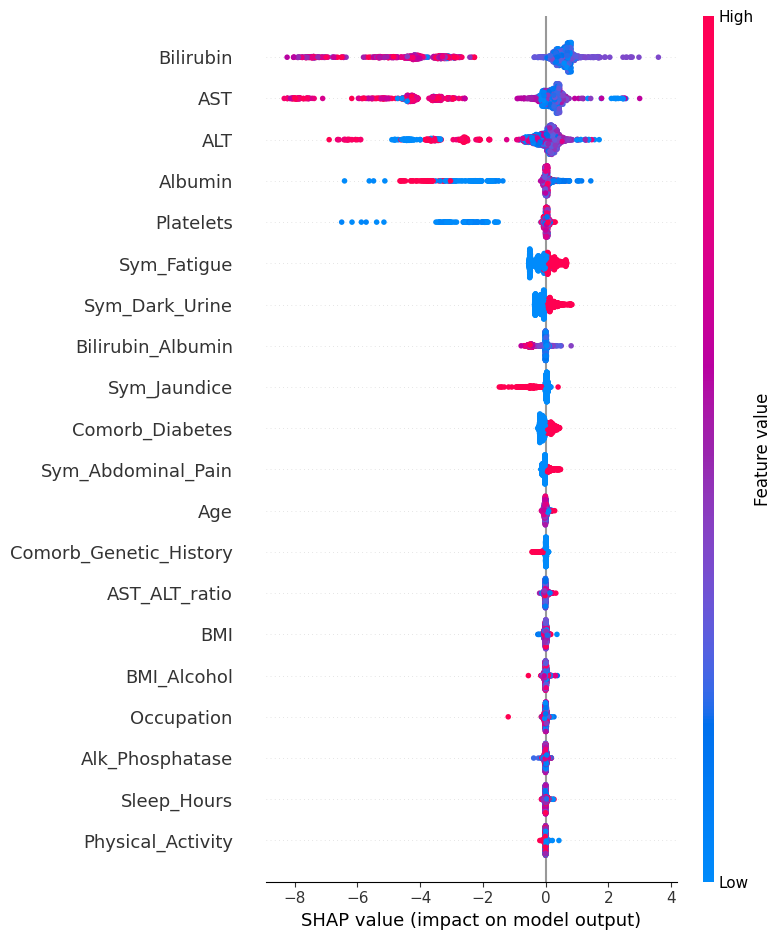

SHAP Summary for Class 3


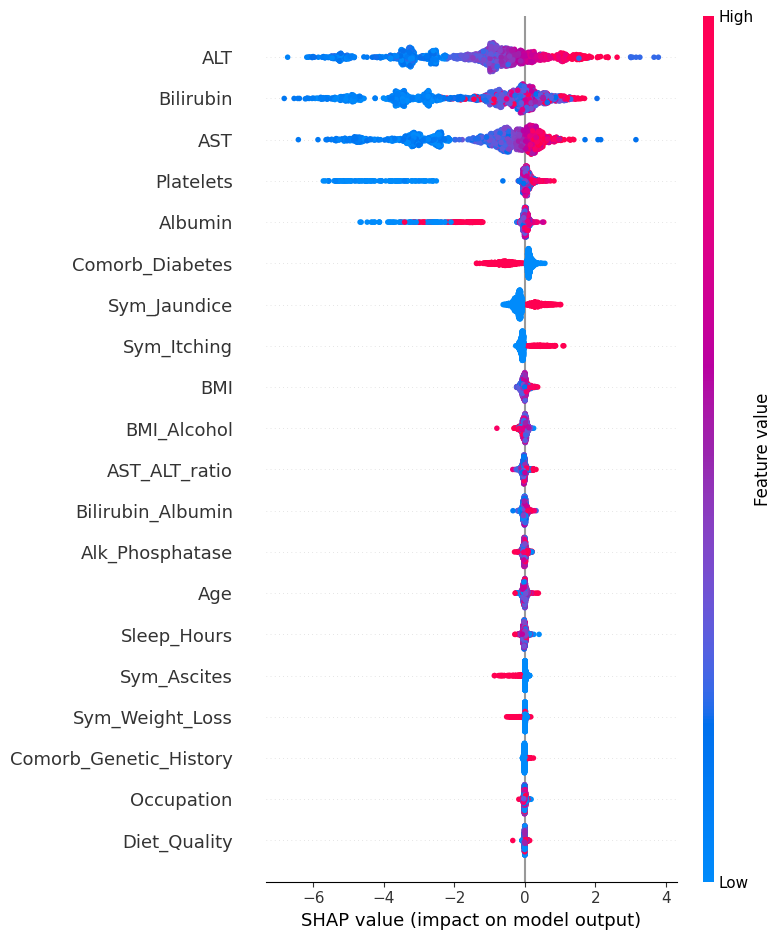

SHAP Summary for Class 4


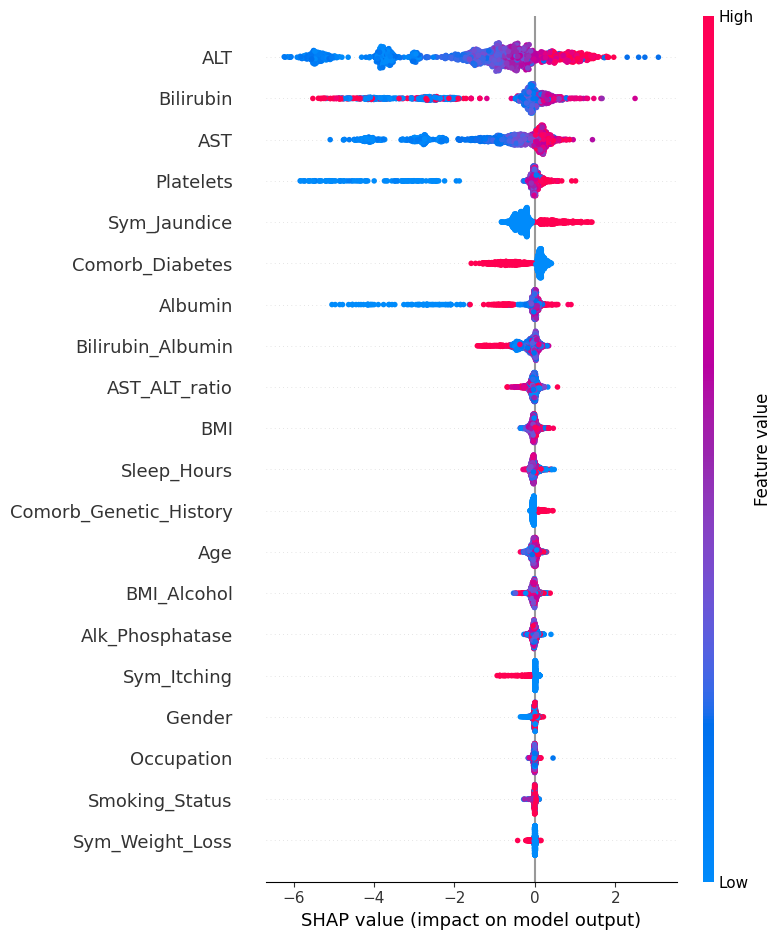

SHAP Summary for Class 5


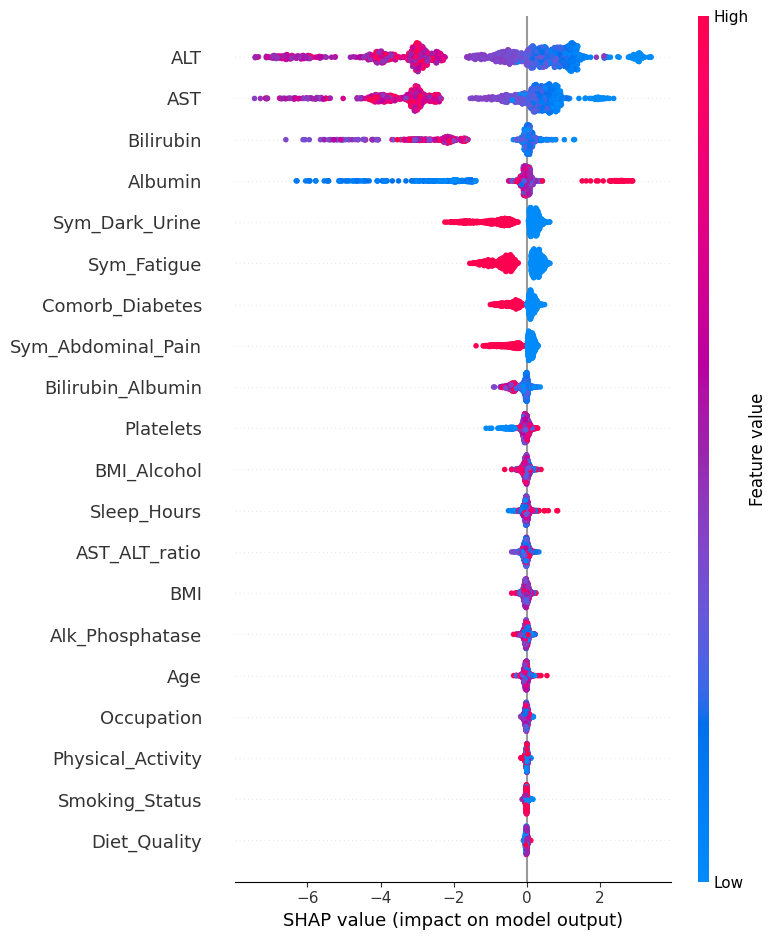

In [ ]:
import shap
import numpy as np

explainer_multi = shap.TreeExplainer(model_multi) #creating a SHAP explainer object for the multi-class XGBoost model, which will be used to compute SHAP values for the test set to understand feature importance across different classes
shap_values_multi = explainer_multi.shap_values(X_test)

if isinstance(shap_values_multi, list):

    for i in range(len(shap_values_multi)): #iterating through each class's SHAP values to create summary plots that show the overall feature importance and how each feature contributes to the predictions for that class
        print(f"SHAP Summary for Class {i}")
        shap.summary_plot(shap_values_multi[i], X_test)

else:
    
    for i in range(shap_values_multi.shape[2]):
        print(f"SHAP Summary for Class {i}")
        shap.summary_plot(shap_values_multi[:, :, i], X_test) #creating summary plots for each class to visualize feature importance and the impact of features on the model's predictions for each class

In [ ]:
import numpy as np

if isinstance(shap_values_multi, list):
    class_shap = shap_values_multi[1] #selecting the SHAP values for the second class (class 1) to analyze the feature contributions specifically for that class, which can help identify which features are most influential in predicting that class
else:
    class_shap = shap_values_multi[:, :, 1] #creating dependence plots for specific features to visualize how the value of each feature affects the SHAP values and thus the model's predictions for that class, which can help identify any non-linear relationships or interactions between features and the target variable

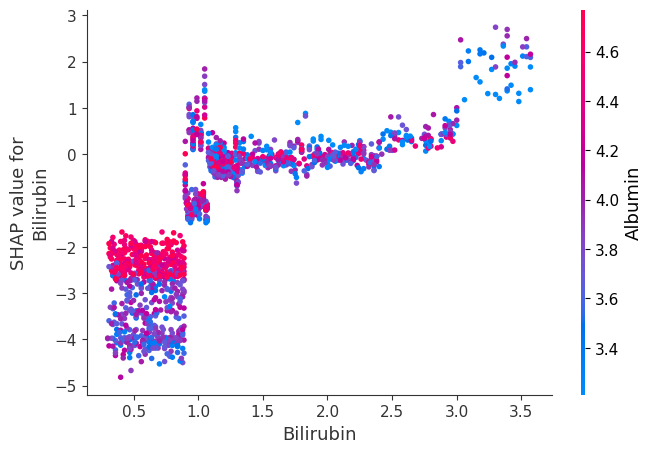

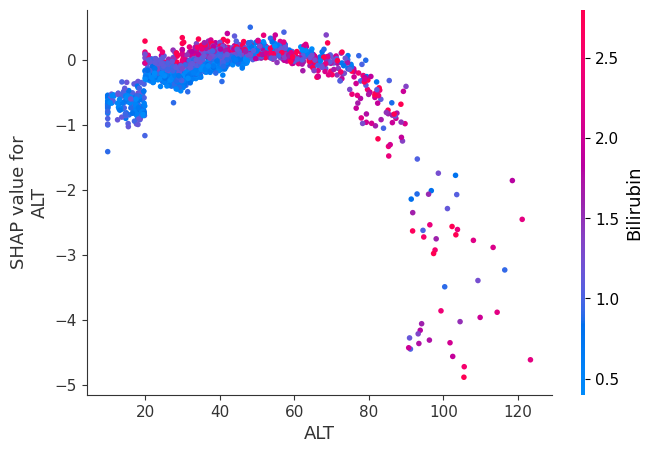

In [ ]:
shap.dependence_plot("Bilirubin", class_shap, X_test) #creating a dependence plot for the "Bilirubin" feature to visualize how changes in bilirubin levels affect the SHAP values and thus the model's predictions for class 1, which can help identify any non-linear relationships or interactions between bilirubin and the target variable
shap.dependence_plot("ALT", class_shap, X_test)

In [ ]:
def generate_explanation(model, X_sample):
    explainer = shap.TreeExplainer(model)
    shap_vals = explainer.shap_values(X_sample)
    
    contrib = dict(zip(X_sample.columns, shap_vals[0]))
    top = sorted(contrib.items(), key=lambda x: abs(x[1]), reverse=True)[:5]
    
    explanation = []
    for f,v in top:
        direction = "increases" if v > 0 else "reduces"
        explanation.append(f"{f} {direction} predicted risk") #generating a concise explanation of the top 5 features contributing to the model's prediction for the given patient profile, indicating whether each feature increases or reduces the predicted risk of liver disease
        
    return explanation

generate_explanation(model_bin, patient_df)

['Albumin reduces predicted risk',
 'Sym_Jaundice reduces predicted risk',
 'AST reduces predicted risk',
 'Bilirubin reduces predicted risk',
 'Alk_Phosphatase increases predicted risk']

In [ ]:
lifestyle_cols = [
    "BMI","Diet_Quality","Physical_Activity",
    "Sleep_Hours","Smoking_Status","Alcohol_Consumption"
]

clinical_cols = [
    "ALT","AST","Bilirubin","Albumin",
    "Platelets","Alk_Phosphatase"
]

model_life = XGBClassifier(n_estimators=600)
model_life.fit(X_train[lifestyle_cols], y_train_binary)
acc_life = accuracy_score(
    y_test_binary,
    model_life.predict(X_test[lifestyle_cols]) #evaluating the accuracy of the model trained only on lifestyle features to understand how well lifestyle factors alone can predict liver disease risk
)

model_clin = XGBClassifier(n_estimators=600)
model_clin.fit(X_train[clinical_cols], y_train_binary)
acc_clin = accuracy_score(
    y_test_binary,
    model_clin.predict(X_test[clinical_cols]) #evaluating the accuracy of the model trained only on clinical features to understand how well clinical factors alone can predict liver disease risk
)

model_comb = XGBClassifier(n_estimators=600)
model_comb.fit(X_train, y_train_binary)
acc_comb = accuracy_score(
    y_test_binary,
    model_comb.predict(X_test) #evaluating the accuracy of the model trained on all features to understand how well the combination of lifestyle and clinical factors can predict liver disease risk compared to using either set of features alone
)

print("Lifestyle Accuracy:", acc_life)
print("Clinical Accuracy:", acc_clin)
print("Combined Accuracy:", acc_comb)

Lifestyle Accuracy: 0.866
Clinical Accuracy: 0.9253333333333333
Combined Accuracy: 0.9693333333333334


In [18]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["Lifestyle Only", "Clinical Only", "Combined"],
    "Accuracy": [acc_life, acc_clin, acc_comb]
})

results

,Model,Accuracy
0,Lifestyle Only,0.866000
1,Clinical Only,0.925333
2,Combined,0.969333


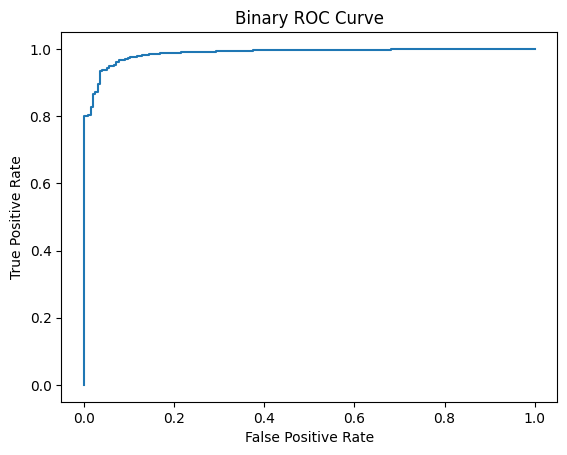

AUC: 0.986898516553689


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

probs = model_bin.predict_proba(X_test)[:,1] #predicting the probabilities of the positive class (liver disease) for the test set, which will be used to compute the ROC curve and AUC to evaluate the model's performance across different classification thresholds
fpr, tpr, _ = roc_curve(y_test_binary, probs) #calculating the false positive rate and true positive rate at various threshold settings to create the ROC curve, which helps evaluate the model's performance across different classification thresholds
roc_auc = auc(fpr, tpr) #calculating the area under the ROC curve (AUC) to summarize the model's performance across all classification thresholds, where a higher AUC indicates better overall performance in distinguishing between the positive and negative classes

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Binary ROC Curve")
plt.show()

print("AUC:", roc_auc)

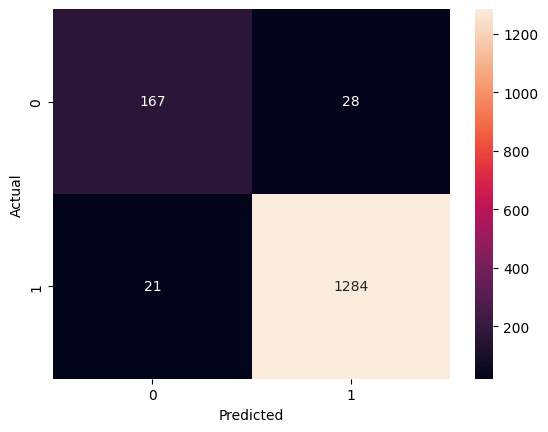

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_binary, preds_bin) #computing the confusion matrix to evaluate the performance of the binary classification model in terms of true positives, true negatives, false positives, and false negatives, which can help identify any issues with class imbalance or specific types of misclassifications

sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

The binary model achieved an accuracy of 96.9%, demonstrating strong capability for early screening applications. The multi-class model further enabled detailed severity differentiation across six disease categories, providing a more granular understanding of patient condition.

An ablation study revealed that clinical biomarkers (ALT, AST, Bilirubin, Albumin, Platelets, and Alkaline Phosphatase) contribute more strongly to predictive performance than lifestyle features alone. However, combining lifestyle and clinical indicators significantly improved overall accuracy, highlighting the complementary relationship between behavioral risk factors and physiological measurements.

Explainability analysis using SHAP provided both global and patient-level interpretability. Global feature importance identified bilirubin, liver enzymes, and alcohol consumption as dominant predictors. Local explanations enabled individualized reasoning for each prediction, enhancing transparency and clinical trust.